### Main file

In [6]:
import numpy as np 
from tools.srbm_experimental import *           # !!! Importing the experimental SRBM model !!!
from tools.functions import *
import matplotlib.pyplot as plt

date_str = str(datetime.datetime.now())[0:10]
date_time_str = str(datetime.datetime.now())[0:10]+"_"+str(datetime.datetime.now())[11:16]

In [7]:
'''Load data that has been generated with "generate_data.py".
The file will be named according to the following pattern:  
data + number of classes + variation in prototype + variation in prototype replications + length stimuli + n datapoints
parameters in "common_parameters.py" need to be adjusted to fit the data. 
'''

length_stimuli = 100
num_classes = 5

# Loading the data
train_test_sequence_data = load_data(unique="finnegan_0.1_0.05_5_200_1000")

if length_stimuli != N_v or num_classes != n_classes:
    print("The data does not fit the parameters in common_parameters.py. Please adjust the parameters in common_parameters.py to fit the data.")

Data loaded from data/data_finnegan_0.1_0.05_5_200_1000.npy


In [2]:
# Preparing the data
sequence_data = get_data(n_samples=n_samples, min_p = .00001, max_p = .98, binary = True, seed=0, 
                           load_from_drive=False, data=train_test_sequence_data, num_classes = range(n_classes))

NameError: name 'get_data' is not defined

In [4]:
# Create input current from data
Id = create_Id(N_v=N_v, N_c=N_c, n_c_unit=n_c_unit, beta=beta_parameter, n_samples=n_samples, data = sequence_data)

# Create the parameters for the SRBM
W, b_v, b_c, b_h = create_rbm_parameters(N_v = N_v, N_c = N_c, N_h = N_h)

In [5]:
# Run the model
loc = main(W, b_v, b_c, b_h, Id = Id, dorun = True, monitors = True, mnist_data=sequence_data, n_classes = 5)
locals().update(loc)

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


Train accuracy: 0.2
Test accuracy: 0.228
Train accuracy: 0.25
Test accuracy: 0.285
Train accuracy: 0.165
Test accuracy: 0.192
Train accuracy: 0.165
Test accuracy: 0.192
Train accuracy: 0.165
Test accuracy: 0.192
Train accuracy: 0.165
Test accuracy: 0.192
Train accuracy: 0.245
Test accuracy: 0.21
Train accuracy: 0.365
Test accuracy: 0.392
Train accuracy: 0.22
Test accuracy: 0.26
Train accuracy: 0.59
Test accuracy: 0.591
Train accuracy: 0.51
Test accuracy: 0.513
Train accuracy: 0.435
Test accuracy: 0.419
Train accuracy: 0.38
Test accuracy: 0.348
Train accuracy: 0.2
Test accuracy: 0.212
Train accuracy: 0.43
Test accuracy: 0.419
Train accuracy: 0.435
Test accuracy: 0.414
Train accuracy: 0.225
Test accuracy: 0.245
Train accuracy: 0.21
Test accuracy: 0.229
Train accuracy: 0.205
Test accuracy: 0.216
Train accuracy: 0.33
Test accuracy: 0.345
Train accuracy: 0.52
Test accuracy: 0.55
Train accuracy: 0.59
Test accuracy: 0.588
Train accuracy: 0.305
Test accuracy: 0.344
Train accuracy: 0.78
Test ac

In [6]:
neuron_group_rhidden.age

<neurongroup_1.age: array([-0.76285742,  0.55272665, -0.14445119, -0.4419379 ,  0.84068506,
        0.19650754, -0.52375259,  0.1946013 , -0.61210238,  0.535514  ,
        0.44927026, -0.83686172, -0.46906013,  0.20925973, -0.30143464,
       -0.36834548, -0.55525956, -0.55354283, -0.46152095,  0.03171202,
       -0.04729484,  0.47848979, -0.50101362,  0.63549107,  0.5492098 ,
        0.41702771,  0.59765821,  0.30913905, -0.91679657,  0.371201  ,
        0.62145509,  0.55642819, -0.44178525,  0.72575576, -0.19565846,
       -0.73838046, -0.21599644,  0.06167885, -0.35022281, -0.45918212,
       -0.51821603,  0.7903359 ,  0.42400687,  0.32471299,  0.2931423 ,
        0.69884306,  0.93092463, -0.61186725, -0.45581224,  0.08494413])>

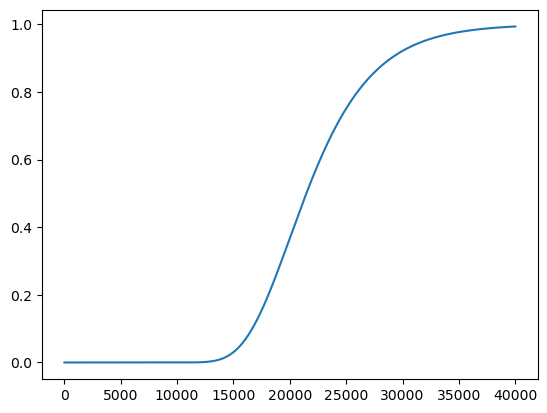

In [7]:
plot(growth_factor_list)
plt.show()


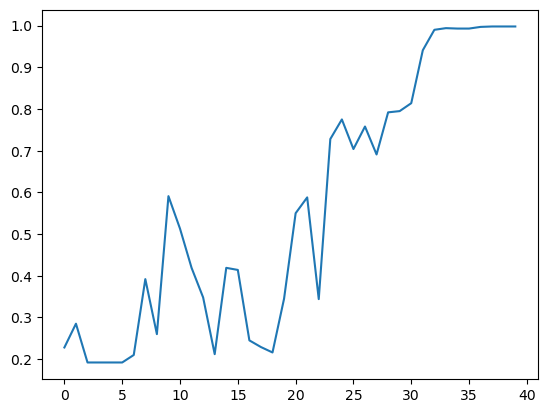

In [8]:
plot(res_hist_test)
plt.show()

In [9]:
# Prepare weights and biases

W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta_parameter
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
mBv = np.array(Sbv.w)*beta_parameter*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta_parameter*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

In [10]:
# Save the weights and biases

save_matrices(W, Wvh, Wch, mBv, mBh, b_c, b_v, b_h, mB, date_str, date_time_str)

Matrices saved to output/output/2023-04-25/10-48
